# Load Train Data

In [1]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt

df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
print( df.shape )
display( df.head() )

# CHOICE TO CREATE OR LOAD EEGS FROM NOTEBOOK VERSION 1
CREATE_EEGS = False
TRAIN_MODEL = True

(106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


# Raw EEG Features

In [2]:
print('We will use the following subset of raw EEG features:')
FEATS = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
FEAT2IDX = {x:y for x,y in zip(FEATS,range(len(FEATS)))}
print( list(FEATS) )

We will use the following subset of raw EEG features:
['Fp1', 'T3', 'C3', 'O1', 'Fp2', 'C4', 'T4', 'O2']


In [3]:
def eeg_from_parquet(parquet_path, display=False):
    
    # EXTRACT MIDDLE 50 SECONDS
    eeg = pd.read_parquet(parquet_path, columns=FEATS)
    #rows = len(eeg)
    #offset = (rows-10_000)//2
    eeg = eeg.iloc[:10_000]
    
    if display: 
        plt.figure(figsize=(10,5))
        offset = 0
    
    # CONVERT TO NUMPY
    data = np.zeros((10_000,len(FEATS)))
    for j,col in enumerate(FEATS):
        
        # FILL NAN
        x = eeg[col].values.astype('float32')
        m = np.nanmean(x)
        if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
        else: x[:] = 0
            
        data[:,j] = x
        
        if display: 
            if j!=0: offset += x.max()
            plt.plot(range(10_000),x-offset,label=col)
            offset -= x.min()
            
    if display:
        plt.legend()
        name = parquet_path.split('/')[-1]
        name = name.split('.')[0]
        plt.title(f'EEG {name}',size=16)
        plt.show()
        
    return data

In [4]:
def eeg_from_parquet10(parquet_path, display=False):
    
    # EXTRACT MIDDLE 10 SECONDS
    eeg = pd.read_parquet(parquet_path, columns=FEATS)
    #rows = len(eeg)
    #offset = (rows-10_000)//2
    eeg = eeg.iloc[4_000:6_000]
    
    if display: 
        plt.figure(figsize=(10,5))
        offset = 0
    
    # CONVERT TO NUMPY
    data = np.zeros((2_000,len(FEATS)))
    for j,col in enumerate(FEATS):
        
        # FILL NAN
        x = eeg[col].values.astype('float32')
        m = np.nanmean(x)
        if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
        else: x[:] = 0
            
        data[:,j] = x
        
        if display: 
            if j!=0: offset += x.max()
            plt.plot(range(2_000),x-offset,label=col)
            offset -= x.min()
            
    if display:
        plt.legend()
        name = parquet_path.split('/')[-1]
        name = name.split('.')[0]
        plt.title(f'EEG {name}',size=16)
        plt.show()
        
    return data

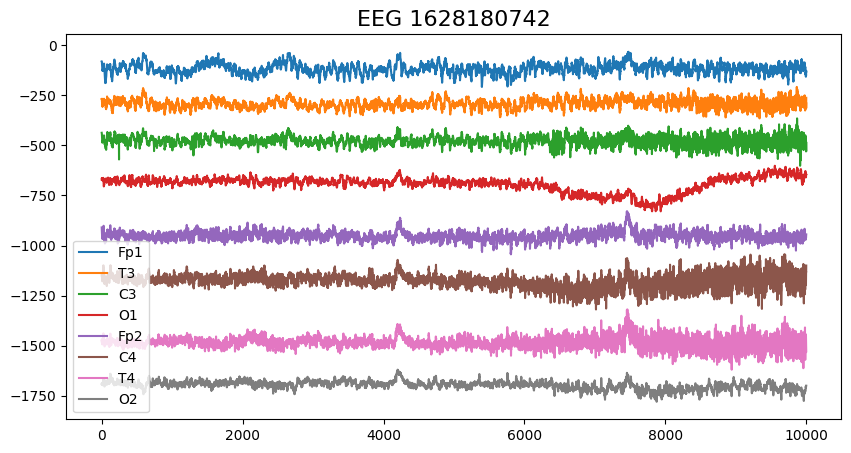

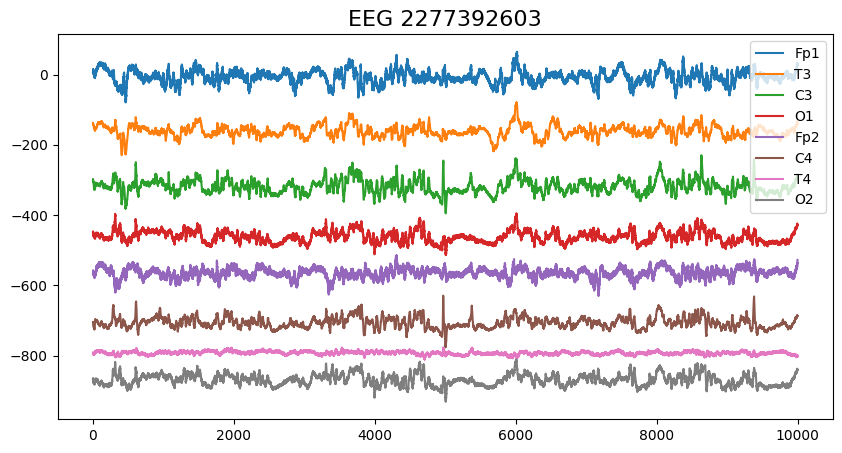

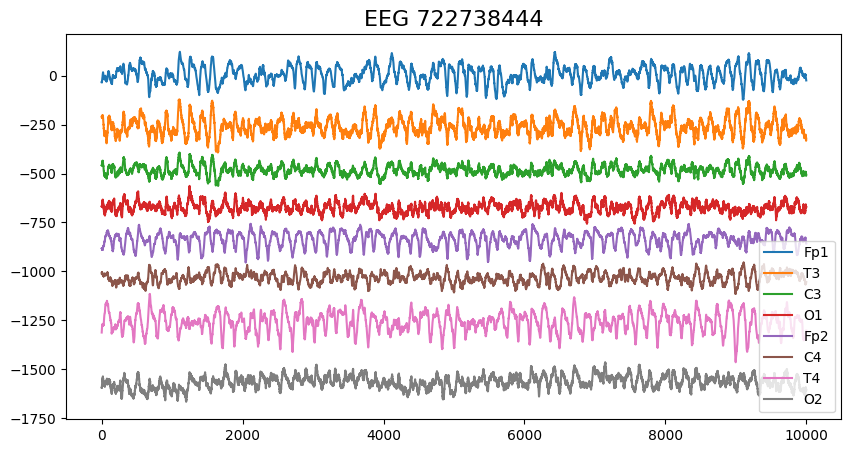

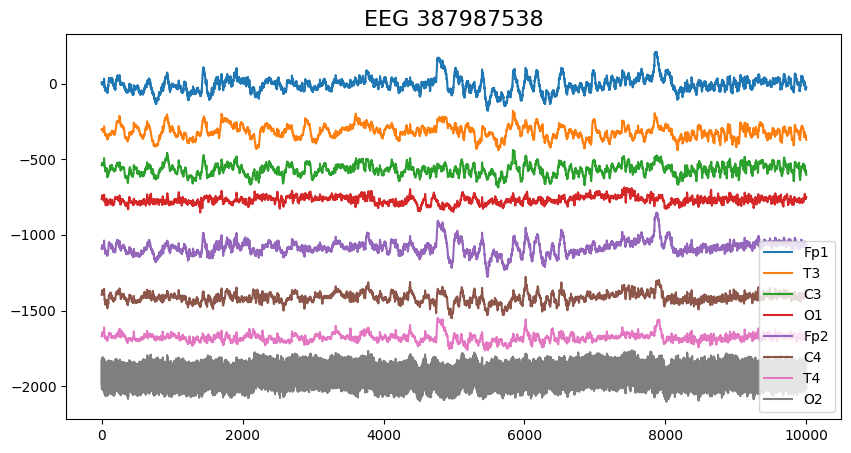

Reading 17089 eeg NumPys from disk.
CPU times: user 13.2 s, sys: 14.9 s, total: 28.1 s
Wall time: 3min 27s


In [5]:
%%time

all_eegs = {}
DISPLAY = 4
EEG_IDS = df.eeg_id.unique()
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/'

for i,eeg_id in enumerate(EEG_IDS):
    if (i%100==0)&(i!=0): print(i,', ',end='') 
    
    # SAVE EEG TO PYTHON DICTIONARY OF NUMPY ARRAYS
    data = eeg_from_parquet(f'{PATH}{eeg_id}.parquet', display=i<DISPLAY)              
    all_eegs[eeg_id] = data
    
    if i==DISPLAY:
        if CREATE_EEGS:
            print(f'Processing {train.eeg_id.nunique()} eeg parquets... ',end='')
        else:
            print(f'Reading {len(EEG_IDS)} eeg NumPys from disk.')
            break
            
if CREATE_EEGS: 
    np.save('eegs',all_eegs)
else:
    all_eegs = np.load('/kaggle/input/10s-50s-eeg-snippets/eegs_pop1.npy',
                       allow_pickle=True).item()

# Deduplicate Train EEG Id

In [6]:
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))

df['total_evaluators'] = df[['seizure_vote', 'lpd_vote', 'gpd_vote', 
                             'lrda_vote', 'grda_vote', 'other_vote']].sum(axis=1)
pop2 = df.loc[df['total_evaluators']>8]

df_uniq = df.drop_duplicates(subset=['eeg_id'] + list(TARGETS))
# df_uniq = df_uniq.sort_values('eeg_id', ascending=True)
print(f'There are {df.patient_id.nunique()} patients in the training data.')
print(f'There are {df.eeg_id.nunique()} EEG IDs in the training data.')
print(f'There are {df_uniq.shape[0]} unique eeg_id + votes in the training data.')

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
There are 1950 patients in the training data.
There are 17089 EEG IDs in the training data.
There are 20183 unique eeg_id + votes in the training data.


In [7]:
train = df[df['label_id'].isin(all_eegs.keys())].copy()
train2 = pop2[pop2['label_id'].isin(all_eegs.keys())].copy()

pop_1_idx = train['total_evaluators'] <=7
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

train['target'] = train['expert_consensus']

y_data = train2[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train2[TARGETS] = y_data

train2['target'] = train2['expert_consensus']

    
train_pop_1 = train[pop_1_idx].copy().reset_index()
train_pop_2 = train[~pop_1_idx].copy().reset_index()
train = train.reset_index()
train2 = train2.reset_index()
print('Pop 1: train unique eeg_id + votes shape:', train_pop_1.shape )
print('Pop 2: train unique eeg_id + votes shape:', train2.shape )
print('Pop: train unique eeg_id + votes shape:', train.shape )

Pop 1: train unique eeg_id + votes shape: (13833, 18)
Pop 2: train unique eeg_id + votes shape: (6350, 18)
Pop: train unique eeg_id + votes shape: (20183, 18)


# Butter Low-Pass Filter

In [8]:
from scipy.signal import butter, lfilter

def butter_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Wavelet Denoise

In [9]:
import pywt

def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='dmey', level=1):
    ret = np.zeros((10_000,8))

    for pos in range(x.shape[1]):
        coeff = pywt.wavedec(x[:,pos], wavelet, mode="per")
        sigma = (1/0.6745) * maddest(coeff[-level])

        uthresh = sigma * np.sqrt(2*np.log(len(x)))
        coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

        ret[:,pos]=pywt.waverec(coeff, wavelet, mode='per')

    return ret

# Data Loader with Butter Low-Pass Filter

In [10]:
import tensorflow as tf

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, batch_size=32, shuffle=False, eegs=all_eegs, mode='train',
                 downsample=5, length=10_000): 

        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.eegs = eegs
        self.mode = mode
        self.downsample = downsample
        self.length = length
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int( np.ceil( len(self.data) / self.batch_size ) )
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X[:,::self.downsample,:], y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( len(self.data) )
        if self.shuffle: np.random.shuffle(self.indexes)
                        
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
    
        X = np.zeros((len(indexes),self.length,8),dtype='float32')
        y = np.zeros((len(indexes),6),dtype='float32')
        
        sample = np.zeros((self.length,X.shape[-1]))
        for j,i in enumerate(indexes):
            row = self.data.iloc[i]      
            data = self.eegs[row.label_id]
            
            # FEATURE ENGINEER
            sample[:,0] = data[:,FEAT2IDX['Fp1']] - data[:,FEAT2IDX['T3']]
            sample[:,1] = data[:,FEAT2IDX['T3']] - data[:,FEAT2IDX['O1']]
            
            sample[:,2] = data[:,FEAT2IDX['Fp1']] - data[:,FEAT2IDX['C3']]
            sample[:,3] = data[:,FEAT2IDX['C3']] - data[:,FEAT2IDX['O1']]
            
            sample[:,4] = data[:,FEAT2IDX['Fp2']] - data[:,FEAT2IDX['C4']]
            sample[:,5] = data[:,FEAT2IDX['C4']] - data[:,FEAT2IDX['O2']]
            
            sample[:,6] = data[:,FEAT2IDX['Fp2']] - data[:,FEAT2IDX['T4']]
            sample[:,7] = data[:,FEAT2IDX['T4']] - data[:,FEAT2IDX['O2']]
            
            # STANDARDIZE
            sample = np.clip(sample,-1024,1024)
            sample = np.nan_to_num(sample, nan=0) / 32.0
            
            # BUTTER LOW-PASS FILTER
            sample = butter_lowpass_filter(sample)
            # sample = denoise(sample)
            
            X[j,] = sample
            if self.mode!='test':
                y[j] = row[TARGETS]
            
        return X,y

# Initialize GPUs

In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
print('TensorFlow version =',tf.__version__)

# USE MULTIPLE GPUS
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1: 
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

TensorFlow version = 2.13.0
Using 2 GPUs


In [12]:
# USE MIXED PRECISION
MIX = True
if MIX:
    tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
    print('Mixed precision enabled')
else:
    print('Using full precision')

Mixed precision enabled


# Build WaveBeat Model

In [13]:
import keras
from keras.models import Model
from keras.layers import Conv1D, BatchNormalization, Input, Add, PReLU, Dropout
from keras.activations import elu

In [14]:
def tcnblock(x, filters, kernel_size, strides, dilation):
    
    res_x = x
   
    #pad_value =  ((kernel_size-1) * dilation) // 2
    
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', 
               activation='elu', strides=strides,
               dilation_rate=dilation)(x)
    #x = keras.layers.LeakyReLU()(x)
    x = BatchNormalization()(x)
    #x = keras.layers.ELU()(x)

    
    res_x = Conv1D(filters=filters, kernel_size=1, strides=strides)(res_x)
    
    return Add()([x, res_x])

In [15]:
def wavebeat(x, stacks, kernel_size=10, stride=1, dilation_growth=2):
    
    for n in range(stacks):
        filters = 32+n*32
        dilation = dilation_growth ** (n % stacks)
        x = tcnblock(x, filters, kernel_size=kernel_size, strides=stride, dilation=dilation)
        #x2 = tcnblock(x, filters, kernel_size=3, strides=stride, dilation=dilation)
    
    #x = tf.keras.Layers.Concatenate()([x1,x2])
    return x

In [16]:
def build_model50(blocks=2):
   
    inp = Input(shape=(2_000,8))
    
    # FEATURE EXTRACTION SUB MODEL
    inp2 = tf.keras.Input(shape=(2_000,1))
    x = wavebeat(inp2, stacks=4)
    for n in range(blocks-1):
        x = wavebeat(x, stacks=4)
    model2 = tf.keras.Model(inputs=inp2, outputs=x)
    ###########
    
    # LEFT TEMPORAL CHAIN
    x1 = model2(inp[:,:,0:1])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,1:2])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z1 = tf.keras.layers.Average()([x1,x2])
    
    # LEFT PARASAGITTAL CHAIN
    x1 = model2(inp[:,:,2:3])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,3:4])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z2 = tf.keras.layers.Average()([x1,x2])
    
    # RIGHT PARASAGITTAL CHAIN
    x1 = model2(inp[:,:,4:5])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,5:6])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z3 = tf.keras.layers.Average()([x1,x2])
    
    # RIGHT TEMPORAL CHAIN
    x1 = model2(inp[:,:,6:7])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,7:8])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z4 = tf.keras.layers.Average()([x1,x2])
    
    # COMBINE CHAINS
    y = tf.keras.layers.Concatenate()([z1,z2,z3,z4])
    y = tf.keras.layers.Dense(64, activation='relu')(y)
    y = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(y)
    
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=y)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer = opt)
    
    return model

In [17]:
def build_model10(blocks=2):
   
    inp = Input(shape=(1_000,8))
    
    # FEATURE EXTRACTION SUB MODEL
    inp2 = tf.keras.Input(shape=(1_000,1))
    x = wavebeat(inp2, stacks=4, kernel_size=3)
    for n in range(blocks-1):
        x = wavebeat(x, stacks=4, kernel_size=3)
    model2 = tf.keras.Model(inputs=inp2, outputs=x)
    ###########
    
    # LEFT TEMPORAL CHAIN
    x1 = model2(inp[:,:,0:1])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,1:2])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z1 = tf.keras.layers.Average()([x1,x2])
    
    # LEFT PARASAGITTAL CHAIN
    x1 = model2(inp[:,:,2:3])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,3:4])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z2 = tf.keras.layers.Average()([x1,x2])
    
    # RIGHT PARASAGITTAL CHAIN
    x1 = model2(inp[:,:,4:5])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,5:6])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z3 = tf.keras.layers.Average()([x1,x2])
    
    # RIGHT TEMPORAL CHAIN
    x1 = model2(inp[:,:,6:7])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,7:8])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z4 = tf.keras.layers.Average()([x1,x2])
    
    # COMBINE CHAINS
    y = tf.keras.layers.Concatenate()([z1,z2,z3,z4])
    y = tf.keras.layers.Dense(64, activation='relu')(y)
    y = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(y)
    
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=y)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer = opt)
    
    return model

# Train Group KFold

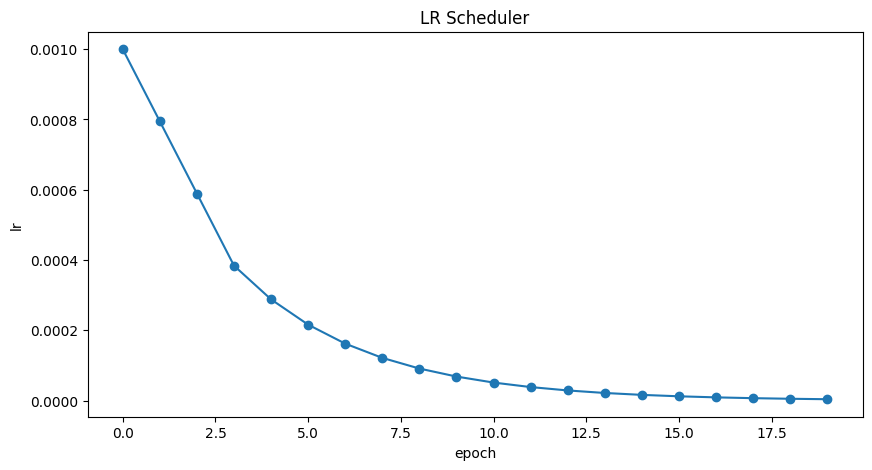

In [18]:
import math
import keras

def get_lr_callback(batch_size=32, mode='cos', epochs=20, plot=False):
    lr_start, lr_max, lr_min = 1e-3, 6e-6 * batch_size, 1e-8
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  

LR = get_lr_callback(64, mode="exp", plot=True)

In [19]:
LR= tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    verbose=0,
    mode="auto",
    min_delta=0.00001,
    cooldown=0,
    min_lr=0.00000000001
)

In [20]:
ckpt_cb = keras.callbacks.ModelCheckpoint("best_model.h5",
                                         monitor='val_loss',
                                         save_best_only=True,
                                         save_weights_only=False,
                                         mode='min')

In [21]:
ckpt_cb2 = keras.callbacks.ModelCheckpoint("best_model2.h5",
                                         monitor='val_loss',
                                         save_best_only=True,
                                         save_weights_only=False,
                                         mode='min')

In [22]:
VERBOSE = 1
FOLDS_TO_TRAIN = 5

os.makedirs('WaveBeat_Model', exist_ok=True)

from sklearn.model_selection import KFold, GroupKFold, StratifiedGroupKFold
import tensorflow.keras.backend as K, gc

all_oof = []; all_oof2 = []; all_true = []
sgkf = StratifiedGroupKFold(n_splits=5)

In [23]:

for i, (train_index, valid_index) in enumerate(sgkf.split(train, train.target, train.patient_id)):   
    
    # Generate Training Data
    print('#'*25)
    print(f'### Fold {i+1}')
    train_gen = DataGenerator(train.iloc[train_index], shuffle=True, batch_size=32)
    valid_gen = DataGenerator(train.iloc[valid_index], shuffle=False, batch_size=64, mode='valid')
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)
    
    # TRAIN MODEL
    K.clear_session()
    with strategy.scope():
        model = build_model50()
    if TRAIN_MODEL:
        model.fit(train_gen, verbose=VERBOSE,
              validation_data = valid_gen,
              epochs=20, callbacks = [LR, ckpt_cb])
        model.load_weights('best_model.h5')
        model.save_weights(f'WaveBeat_Model/WaveBeat50_fold{i}.h5')
    else:
        model.load_weights(f'/kaggle/input/wavebeat-weights/WaveBeat_Model/WaveBeat_fold{i}.h5')
    
    # WAVENET OOF
    oof = model.predict(valid_gen, verbose=VERBOSE)
    all_oof.append(oof)
    all_true.append(train.iloc[valid_index][TARGETS].values)
    
    # TRAIN MEAN OOF
    y_train = train.iloc[train_index][TARGETS].values
    y_valid = train.iloc[valid_index][TARGETS].values
    oof = y_valid.copy()
    for j in range(6):
        oof[:,j] = y_train[:,j].mean()
    oof = oof / oof.sum(axis=1,keepdims=True)
    all_oof2.append(oof)
    
    del model, oof, y_train, y_valid
    gc.collect()
    
    if i==FOLDS_TO_TRAIN-1: break
    
all_oof = np.concatenate(all_oof)
all_oof2 = np.concatenate(all_oof2)
all_true = np.concatenate(all_true)

#########################
### Fold 1
### train size 16146, valid size 4037
#########################
Epoch 1/20
505/505 [==============================] - ETA: 0s - loss: 1.0544

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


505/505 [==============================] - 273s 337ms/step - loss: 1.0544 - val_loss: 1.0469 - lr: 0.0010
Epoch 2/20
505/505 [==============================] - 153s 302ms/step - loss: 0.9189 - val_loss: 1.0833 - lr: 0.0010
Epoch 3/20
505/505 [==============================] - 153s 304ms/step - loss: 0.8467 - val_loss: 1.0044 - lr: 0.0010
Epoch 4/20
505/505 [==============================] - 153s 302ms/step - loss: 0.7878 - val_loss: 0.8843 - lr: 0.0010
Epoch 5/20
505/505 [==============================] - 154s 304ms/step - loss: 0.7500 - val_loss: 1.0015 - lr: 0.0010
Epoch 6/20
505/505 [==============================] - 152s 301ms/step - loss: 0.7301 - val_loss: 1.1521 - lr: 0.0010
Epoch 7/20
505/505 [==============================] - 151s 299ms/step - loss: 0.6541 - val_loss: 0.9204 - lr: 1.0000e-04
Epoch 8/20
505/505 [==============================] - 152s 301ms/step - loss: 0.6364 - val_loss: 0.9037 - lr: 1.0000e-04
Epoch 9/20
505/505 [==============================] - 154s 304ms/st

In [24]:
all_eegs = np.load('/kaggle/input/10seeg/eegs10.npy',
                       allow_pickle=True).item()

In [25]:
VERBOSE = 1
FOLDS_TO_TRAIN = 5

#TRAIN_MODEL = False
#from sklearn.model_selection import KFold, GroupKFold
#import tensorflow.keras.backend as K, gc

all_oof = []; all_oof2 = []; all_true = []
#gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(sgkf.split(train, train.target, train.patient_id)):   
    
    print('#'*25)
    print(f'### Fold {i+1}')
    train_gen = DataGenerator(train.iloc[train_index], length=2_000, eegs=all_eegs, 
                              downsample=2, shuffle=True, batch_size=32)
    valid_gen = DataGenerator(train.iloc[valid_index], length=2_000, eegs=all_eegs,
                              downsample=2,shuffle=False, batch_size=64, mode='valid')
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)
    
    # TRAIN MODEL
    K.clear_session()
    with strategy.scope():
        model = build_model10()
    if TRAIN_MODEL:
        #model.load_weights(f'/kaggle/working/WaveBeat_Model/WaveBeat_fold{i}.h5')
        model.fit(train_gen, verbose=VERBOSE,
              validation_data = valid_gen,
              epochs=20, callbacks = [LR, ckpt_cb2])
        model.load_weights('best_model2.h5')
        model.save_weights(f'WaveBeat_Model/WaveBeat10_fold{i}.h5')
    else:
        model.load_weights(f'/kaggle/input/wavebeat-weights/WaveBeat_Model/Wave2Beat_fold{i}.h5')
    
    # WAVENET OOF
    oof = model.predict(valid_gen, verbose=VERBOSE)
    all_oof.append(oof)
    all_true.append(train.iloc[valid_index][TARGETS].values)
    
    # TRAIN MEAN OOF
    y_train = train.iloc[train_index][TARGETS].values
    y_valid = train.iloc[valid_index][TARGETS].values
    oof = y_valid.copy()
    for j in range(6):
        oof[:,j] = y_train[:,j].mean()
    oof = oof / oof.sum(axis=1,keepdims=True)
    all_oof2.append(oof)
    
    del model, oof, y_train, y_valid
    gc.collect()
    
    if i==FOLDS_TO_TRAIN-1: break
    
all_oof = np.concatenate(all_oof)
all_oof2 = np.concatenate(all_oof2)
all_true = np.concatenate(all_true)

#########################
### Fold 1
### train size 16146, valid size 4037
#########################
Epoch 1/20
505/505 [==============================] - ETA: 0s - loss: 1.0997

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


505/505 [==============================] - 195s 205ms/step - loss: 1.0997 - val_loss: 1.0901 - lr: 0.0010
Epoch 2/20
505/505 [==============================] - 87s 172ms/step - loss: 0.9394 - val_loss: 0.9987 - lr: 0.0010
Epoch 3/20
505/505 [==============================] - 88s 175ms/step - loss: 0.8600 - val_loss: 1.1739 - lr: 0.0010
Epoch 4/20
505/505 [==============================] - 89s 176ms/step - loss: 0.8055 - val_loss: 1.0819 - lr: 0.0010
Epoch 5/20
505/505 [==============================] - 89s 177ms/step - loss: 0.7242 - val_loss: 0.9525 - lr: 1.0000e-04
Epoch 6/20
505/505 [==============================] - 89s 177ms/step - loss: 0.7043 - val_loss: 1.0070 - lr: 1.0000e-04
Epoch 7/20
505/505 [==============================] - 89s 177ms/step - loss: 0.6919 - val_loss: 1.0758 - lr: 1.0000e-04
Epoch 8/20
505/505 [==============================] - 89s 177ms/step - loss: 0.6823 - val_loss: 1.0025 - lr: 1.0000e-05
Epoch 9/20
505/505 [==============================] - 90s 178ms/st

# Submit to Kaggle LB

In [26]:
del all_eegs, train; gc.collect()
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape:',test.shape)
test.head()

Test shape: (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


Processing Test EEG parquets...



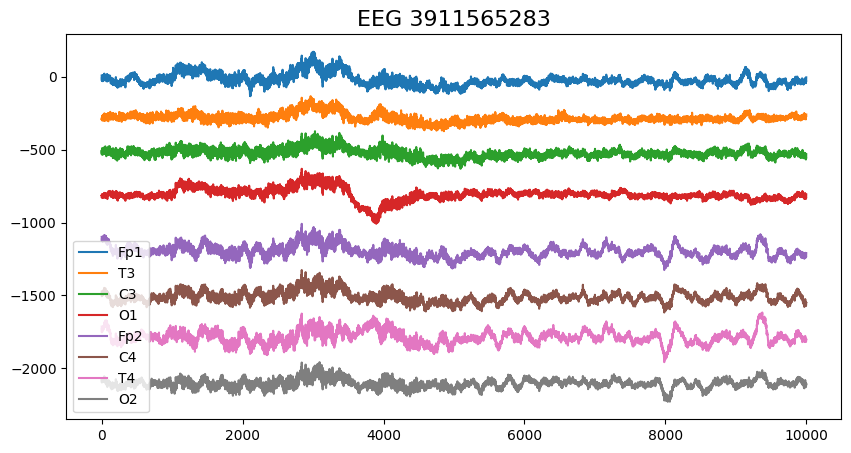

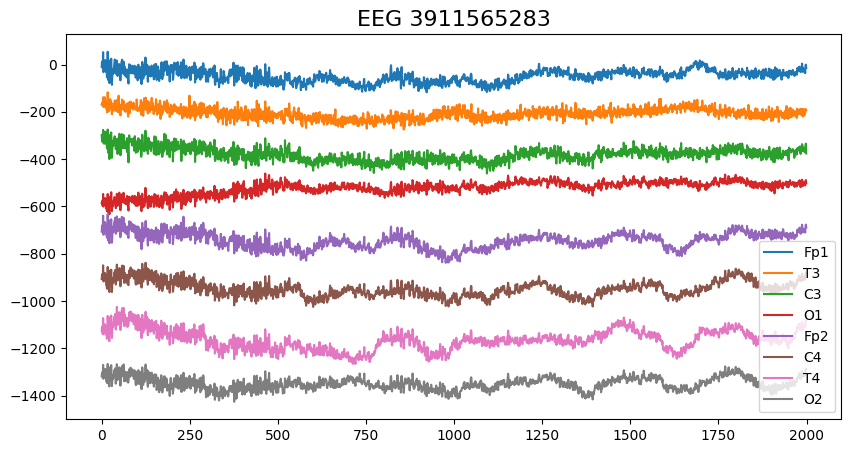

In [27]:
all_eegs2 = {}
all_eegs21 ={}
DISPLAY = 1
EEG_IDS2 = test.eeg_id.unique()
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'

print('Processing Test EEG parquets...'); print()
for i,eeg_id in enumerate(EEG_IDS2):
        
    # SAVE EEG TO PYTHON DICTIONARY OF NUMPY ARRAYS
    data = eeg_from_parquet(f'{PATH2}{eeg_id}.parquet', i<DISPLAY)
    all_eegs2[eeg_id] = data
    
    data2 = eeg_from_parquet10(f'{PATH2}{eeg_id}.parquet', i<DISPLAY)
    all_eegs21[eeg_id] = data2

In [28]:
class EEGDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, batch_size=32, length=10_000, shuffle=False, eegs=all_eegs2, mode='train',
                 downsample=5): 

        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.eegs = eegs
        self.mode = mode
        self.length = length
        self.downsample = downsample
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int( np.ceil( len(self.data) / self.batch_size ) )
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X[:,::self.downsample,:], y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( len(self.data) )
        if self.shuffle: np.random.shuffle(self.indexes)
                        
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
    
        X = np.zeros((len(indexes),self.length,8),dtype='float32')
        y = np.zeros((len(indexes),6),dtype='float32')
        
        sample = np.zeros((self.length,X.shape[-1]))
        for j,i in enumerate(indexes):
            row = self.data.iloc[i]      
            data = self.eegs[row.eeg_id]
            
            # FEATURE ENGINEER
            sample[:,0] = data[:,FEAT2IDX['Fp1']] - data[:,FEAT2IDX['T3']]
            sample[:,1] = data[:,FEAT2IDX['T3']] - data[:,FEAT2IDX['O1']]
            
            sample[:,2] = data[:,FEAT2IDX['Fp1']] - data[:,FEAT2IDX['C3']]
            sample[:,3] = data[:,FEAT2IDX['C3']] - data[:,FEAT2IDX['O1']]
            
            sample[:,4] = data[:,FEAT2IDX['Fp2']] - data[:,FEAT2IDX['C4']]
            sample[:,5] = data[:,FEAT2IDX['C4']] - data[:,FEAT2IDX['O2']]
            
            sample[:,6] = data[:,FEAT2IDX['Fp2']] - data[:,FEAT2IDX['T4']]
            sample[:,7] = data[:,FEAT2IDX['T4']] - data[:,FEAT2IDX['O2']]
            
            # STANDARDIZE
            sample = np.clip(sample,-1024,1024)
            sample = np.nan_to_num(sample, nan=0) / 32.0
            
            # BUTTER LOW-PASS FILTER
            sample = butter_lowpass_filter(sample)
            # sample = denoise(sample)
            
            X[j,] = sample
            if self.mode!='test':
                y[j] = row[TARGETS]
            
        return X,y

In [29]:
# INFER MLP ON TEST
preds = []
model = build_model50()
model2 = build_model10()
test_gen1 = EEGDataGenerator(test, shuffle=False, batch_size=64, eegs=all_eegs2, mode='test')
test_gen2 = EEGDataGenerator(test, shuffle=False, 
                             length=2_000,downsample=2,
                             batch_size=64, eegs=all_eegs21, mode='test')

print('Inferring test... ',end='')
for i in range(FOLDS_TO_TRAIN):
    print(f'fold {i+1}, ',end='')
    if TRAIN_MODEL:
        model.load_weights(f'WaveBeat_Model/WaveBeat50_fold{i}.h5')
        model2.load_weights(f'WaveBeat_Model/WaveBeat10_fold{i}.h5')
    else:
        model.load_weights(f'/kaggle/input/wavebeat-weights/WaveBeat_Model/Wave2Beat_fold{i}.h5')
    pred = model.predict(test_gen1, verbose=0)
    preds.append(pred)
    pred = model2.predict(test_gen2, verbose=0)
    preds.append(pred)
pred = np.mean(preds,axis=0)
print()
print('Test preds shape',pred.shape)

Inferring test... fold 1, fold 2, fold 3, fold 4, fold 5, 
Test preds shape (1, 6)


In [30]:
# CREATE SUBMISSION.CSV
from IPython.display import display

sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
sub[TARGETS] = pred
sub.to_csv('submission.csv',index=False)
print('Submission shape',sub.shape)
display( sub.head() )

# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
print('Sub row 0 sums to:',sub.iloc[0,-6:].sum())

Submission shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.09015,0.033182,0.00274,0.115672,0.078853,0.679403


Sub row 0 sums to: 0.9999999597202986
